## Build a Free Stock Sentiment Analysis Program Using Local LLMs with LangChain and Pydantic

This notebook demonstrates how to perform sentiment analysis on financial news articles using LangChain and OpenAI. We'll analyze the sentiment of companies mentioned in news articles, providing detailed justifications and confidence scores.

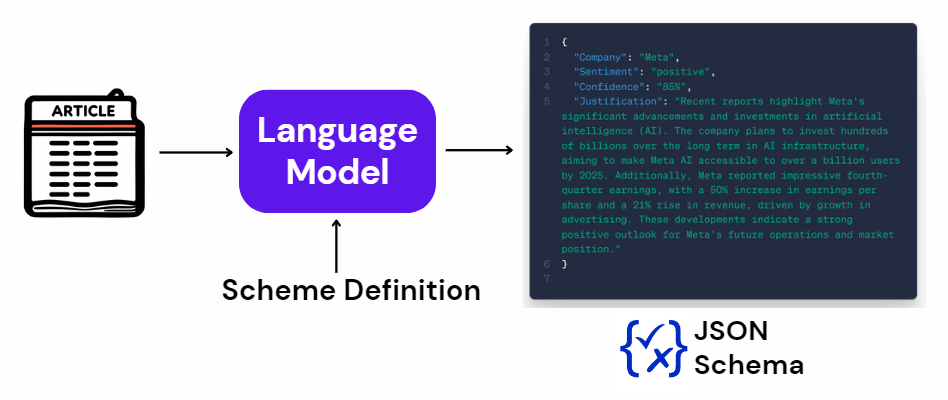

## Table of Contents  
1. Introduction  
2. Setup and Dependencies  
3. Defining the Data Models  
4. Setting Up the Chat Model  
5. Creating the Prompt Template  
6. Processing Chain  
7. Example Analysis  

## Introduction <a name="introduction"></a>
Sentiment analysis is a powerful tool in financial markets, helping investors understand market sentiment towards specific companies. This notebook uses LangChain and OpenAI to analyze news articles and extract sentiment information about mentioned companies.

## Setup and Dependencies <a name="setup"></a>
First, let's ensure we have all necessary dependencies installed.

In [ ]:
!pip install langchain_openai langchain pydantic

Now, let's import the required libraries.

In [1]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field, field_validator
from typing import List, Optional
from enum import Enum
from datetime import datetime
import time

## Defining the Data Models <a name="data-models"></a>  

We define Pydantic models to structure our sentiment analysis output.

In [2]:
class SentimentLabel(str, Enum):
    POSITIVE = "positive"
    MIXED = "mixed"
    NEGATIVE = "negative"

class StockSentiment(BaseModel):
    company_name: str = Field(
        ..., 
        description="The name of the company being analyzed, e.g., NVIDIA Corporation (NVDA)."
    )
    justification: str = Field(
        ..., 
        description="Detailed explanation with specific numbers from the article, supporting the sentiment classification."
    )
    sentiment: SentimentLabel = Field(
        ..., 
        description="Sentiment classification based on the content analysis: positive, neutral, negative, or mixed."
    )
    confidence: float = Field(
        ..., 
        description="Confidence level of the sentiment analysis, ranging from 0 to 1."
    )

    @field_validator("company_name")
    def validate_company_name(cls, v):
        if not v.strip():
            raise ValueError("Company name cannot be empty")
        if len(v) > 100:
            raise ValueError("Company name must be 100 characters or fewer")
        return v

    @field_validator("confidence")
    def validate_confidence(cls, v):
        if not 0 <= v <= 1:
            raise ValueError("Confidence must be between 0 and 1")
        return round(v, 2)  # Round to 2 decimal places for cleaner output

    @field_validator("justification")
    def validate_justification(cls, v):
        if not v.strip():
            raise ValueError("Justification cannot be empty")
        if "±" in v or "≈" in v:  # Prevent approximations
            raise ValueError("Use exact numbers from article, not approximations")
        return v

class NewsSentiment(BaseModel):
    stocks: List[StockSentiment] = Field(
            ...,
            example=[
                {
                    "company_name": "NVIDIA Corporation (NVDA)", 
                    "sentiment": "positive", 
                    "confidence": 0.95, 
                    "justification": "Q4 revenue increased 15% to $22.1 billion driven by AI chip demand"
                },
                {
                    "company_name": "Tesla, Inc. (TSLA)", 
                    "sentiment": "negative", 
                    "confidence": 0.85, 
                    "justification": "Vehicle deliveries dropped 8.5% to 435,000 units in Q3"
                }
            ]
        )
    timestamp: datetime = Field(
        default_factory=datetime.now,
        description="Timestamp of the analysis in ISO format"
    )

    @field_validator("stocks")
    def validate_stocks(cls, v):
        if not v:
            raise ValueError("Stocks list cannot be empty")
        return v

## Setting Up the Chat Model <a name="chat-model"></a>

We initialize the ChatOpenAI model with specific configurations.

In [3]:
model_name = "unsloth/phi-4"

# Initialize Chat model
model = ChatOpenAI(
    model_name=model_name,
    openai_api_base="http://localhost:1234/v1",
    openai_api_key="lm-studio",
    temperature=0 # Set temperature to 0 for deterministic output
)

# Add structured output capability
structured_llm = model.with_structured_output(NewsSentiment)

## Creating the Prompt Template <a name="prompt-template"></a>

We define a detailed system prompt and a user prompt template.

In [4]:
# Create prompt template with detailed system message
system_prompt = """You are a senior financial analyst with expertise in news sentiment analysis. 
When analyzing articles, follow these guidelines:

1. Identify all publicly traded companies mentioned in the text
2. For each company, determine market sentiment based on:
   - Explicit statements about financial performance (include exact figures/percentages)
   - Strategic developments (mergers, partnerships, innovations)
   - Regulatory/legal implications
   - Market reactions (stock movements, analyst ratings)

For each sentiment determination:
- Include SPECIFIC NUMERICAL DATA from the article when available (revenue figures, percentage changes, booking numbers)
- State QUANTIFIED IMPACTS ("9% revenue growth" not just "revenue growth")
- Mention EXACT TIME REFERENCES ("Q4 2023" not just "recently")
- Use PRECISE METRICS from the text ($27.35 billion, 6% stock increase)

Maintain strict requirements:
- Confidence scores must reflect article evidence strength
- Never invent information not explicitly stated
- Use exact company names with ticker symbols
- Prioritize recent information when multiple data points exist"""


user_prompt =   """ 
                    The current date is {current_date}, 
                    analyze the following article and provide sentiment analysis for each publicly traded company 
                    mentioned in the text below:
                    {article}
                """

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", user_prompt)
])

## Processing Chain <a name="processing-chain"></a>

We create a processing chain that combines the prompt and the structured output model.

In [5]:
# Create processing chain
chain = prompt | structured_llm

## Example Analysis <a name="example-analysis"></a>

Let's analyze a sample news article.

In [6]:
# Example usage
article = """

OpenAI Pleads That It Can’t Make Money Without Using Copyrighted Materials for Free
Noor Al-Sibai3-4 minutes 1/9/2024
"It would be impossible to train today’s leading AI models without using copyrighted materials."
Please Sir
OpenAI is begging the British Parliament to allow it to use copyrighted works because it's supposedly "impossible" for the company to train its artificial intelligence models — and continue growing its multi-billion-dollar business — without them.

As The Telegraph reports, the AI firm said in a filing submitted to a House of Lords subcommittee that using only content from the public domain would be insufficient to train the kind of large language models (LLMs) it's building, suggesting that the company must therefore be allowed to use copyrighted material.

"Because copyright today covers virtually every sort of human expression — including blog posts, photographs, forum posts, scraps of software code, and government documents — it would be impossible to train today's leading AI models without using copyrighted materials," the company wrote in the evidence filing. "Limiting training data to public domain books and drawings created more than a century ago might yield an interesting experiment, but would not provide AI systems that meet the needs of today's citizens."

OpenAI went on to insist in the document, submitted before the House of Lords' communications and digital committee, that it complies with copyright laws and that the company believes "legally copyright law does not forbid training."

Rank and File
There's a growing chorus of interested parties who strongly disagree with OpenAI's assertion that it's chill and legal to use copyrighted work to train AI.

Just a few weeks ago, the New York Times sued OpenAI and Microsoft, its biggest investor, for profiting from allegedly "massive copyright infringement, commercial exploitation and misappropriation" of the paper's intellectual property.

The paper of record is far from alone in its legal overtures against OpenAI. A few months prior, the Authors Guild sued the firm on behalf of some of the biggest names in fiction — including John Grisham, Jodi Picoult, Jonathan Franzen, David Baldacci, and George R.R. Martin — over objections to those writers' work being used to train ChatGPT.

Without using copyrighted work, OpenAI "would have a vastly different commercial product," Rachel Geman, one of the attorneys in the guild's class action suit, said in a press release about the filing. As such, the company's "decision to copy authors' works, done without offering any choices or providing any compensation, threatens the role and livelihood of writers as a whole."

On OpenAI's end, the company claims that it's seeking to broker new publisher partnerships, The Telegraph reports. All the same, it's hard to imagine every newspaper, website, or publishing house accepting such terms wholesale, much less independent writers who rely on their copyrights to make a living.

More on authors and AI: AI Companies Desperately Hiring Authors and Poets to Fix Their Crappy Writing

"""

# Update example usage with current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Start the timer
start_time = time.time()

print('Processing article...\n')
result = chain.invoke({"article": article, "current_date": current_date})

# Calculate the elapsed time
elapsed_time = time.time() - start_time

print(f"Model Used: {model_name}")
print(f"Analysis timestamp: {result.timestamp}")
print(f"Time taken to process the article: {elapsed_time:.2f} seconds")

for stock in result.stocks:
    print("**************************************************")
    print(f"Company: {stock.company_name}")
    print(f"Sentiment: {stock.sentiment.value}")
    print(f"Confidence: {stock.confidence:.0%}")  # Format as percentage
    print(f"Justification: {stock.justification}\n")

Processing article...

Model Used: unsloth/phi-4
Analysis timestamp: 2025-01-30 00:00:00+00:00
Time taken to process the article: 10.41 seconds
**************************************************
Company: OpenAI
Sentiment: negative
Confidence: 80%
Justification: The article discusses OpenAI's legal challenges regarding the use of copyrighted materials for training its AI models. The company is facing lawsuits from entities like The New York Times and the Authors Guild, which claim copyright infringement. These legal issues could negatively impact OpenAI's operations and reputation. However, OpenAI argues compliance with copyright laws and seeks new publisher partnerships to mitigate these challenges.

**************************************************
Company: Microsoft Corporation (MSFT)
Sentiment: negative
Confidence: 60%
Justification: The article mentions Microsoft as a major investor in OpenAI, which is involved in legal disputes over copyright infringement claims by The New York T